In [1]:
import sys, os
sys.path.insert(0, '..')
from lib import models, graph, coarsening, utils

import tensorflow as tf
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut
from scipy import stats
import numpy as np

flags = tf.app.flags
FLAGS = flags.FLAGS

# Graphs.
flags.DEFINE_integer('number_edges', 10, 'Graph: minimum number of edges per vertex.')
flags.DEFINE_string('metric', 'euclidean', 'Graph: similarity measure (between features).')
# TODO: change cgcnn for combinatorial Laplacians.
flags.DEFINE_bool('normalized_laplacian', True, 'Graph Laplacian: normalized.')
flags.DEFINE_integer('coarsening_levels', 2, 'Number of coarsened graphs.')

# Directories.
#flags.DEFINE_string('dir_data', os.path.join('..', 'data', 'mnist'), 'Directory to store data.')
def grid_graph(m, corners=False):
    z = graph.grid(m)
    dist, idx = graph.distance_sklearn_metrics(z, k=FLAGS.number_edges, metric=FLAGS.metric)
    A = graph.adjacency(dist, idx)

    # Connections are only vertical or horizontal on the grid.
    # Corner vertices are connected to 2 neightbors only.
    if corners:
        import scipy.sparse
        A = A.toarray()
        A[A < A.max()/1.5] = 0
        A = scipy.sparse.csr_matrix(A)
        print('{} edges'.format(A.nnz))
    print("{} > {} edges".format(A.nnz//2, FLAGS.number_edges*m**2//2))
    return A

t_start = time.process_time()
A = grid_graph(100, corners=False)   #### why 75 here?
A = graph.replace_random_edges(A, 0)
graphs, perm = coarsening.coarsen(A, levels=FLAGS.coarsening_levels, self_connections=False)
L = [graph.laplacian(A, normalized=True) for A in graphs]
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
#graph.plot_spectrum(L)
#del A


##############################################original
features = np.loadtxt(open("../braindata/Y_rho_03.csv", "rb"), delimiter=",", skiprows=0)
features = features.transpose()
features = stats.zscore(features)
print(features.shape)

#y = np.loadtxt(open("../braindata/dx2.csv", "rb"), delimiter=",", skiprows=1,usecols=range(1,209))
y = np.loadtxt(open("../braindata/dx3.csv", "rb"), delimiter=",", skiprows=1,usecols=range(1,209))

print(y.shape)

## select the y label and the indices (excluding NaNs)
y = y[3,:] #1: dx.1ad.2mci.3smi; 2:dx2.1adonly.2adwithsmallvv.3mci.4smi; 3:pureAD1_smi0; 4:pureAD1_MCI0;5:MCI1_smi0;6:pureAD1_MCIandSMI0
ind_num=np.isnan(y)
y = y[~ind_num]
features = features[~ind_num,:]
print(features.shape)


##############################################

#features = np.loadtxt(open("../final_data.csv", "rb"), delimiter=",", skiprows=1, usecols=range(1,94) )
#features = np.loadtxt(open("../final_data_2.csv", "rb"), delimiter=",", skiprows=1, usecols=range(1,91) )
#features = features.transpose()
#features = stats.zscore(features)
#y = np.loadtxt(open("../all_data.csv", "rb"), delimiter=",", skiprows=1, usecols=range(1,94))
#y = np.loadtxt(open("../all_data_2.csv", "rb"), delimiter=",", skiprows=1, usecols=range(1,91))

#y = y[0,:]

bin_ixs = []
train_ixs = []
 
skf = StratifiedKFold(n_splits=10)
for train_index, test_index in skf.split(features, y):
    bin_ixs.append(test_index)

common = {}
common['dir_name']       = 'mnist/'
common['num_epochs']     = 15
common['batch_size']     = 10
common['eval_frequency'] = common['num_epochs']
common['brelu']          = 'b1relu'
common['pool']           = 'mpool1'
C = max(y) + 1  # number of classes

model_perf = utils.model_perf()

53315 > 50000 edges
Layer 0: M_0 = |V| = 10912 nodes (912 added),|E| = 53315 edges
Layer 1: M_1 = |V| = 5456 nodes (234 added),|E| = 24493 edges
Layer 2: M_2 = |V| = 2728 nodes (0 added),|E| = 10635 edges
Execution time: 31.27s
(208, 7993)
(6, 208)
(141, 7993)


In [2]:
total_accuracies = []
all_scores = []
all_labels = []
sep = '*' * 100
for runs in range(10):
    print("\n RUN: {} {} \n".format(runs, sep))
    fold_acc = []
    roc_scores = []
    labels = []
    
    for i in range(skf.get_n_splits(features, y)):
        bins = list(range(skf.get_n_splits(features, y)))
        print("\n Fold: {} {} \n".format(i, sep))
        train_data = np.empty([0,features.shape[1]])
        train_labels = [] 
        val_ix = i
        if val_ix == max(bins):
            test_ix = 0
            bins.remove(val_ix)
            bins.remove(test_ix)

        else:
            test_ix = val_ix + 1
            bins.remove(test_ix)
            bins.remove(val_ix)

        val_data, val_labels = features[bin_ixs[val_ix]], y[bin_ixs[val_ix]]
        test_data, test_labels = features[bin_ixs[test_ix]], y[bin_ixs[test_ix]]
        for b in bins:
            train_data = np.concatenate((train_data, features[bin_ixs[b]]))
            train_labels = np.concatenate((train_labels, y[bin_ixs[b]]))

        #print(train_data.shape)
        #print(val_data.shape)
        #print(test_data.shape)
        
        #print(len(train_data))
        
        #t=train_data.transpose()
        #print(len(t))

        #break
        t_start = time.process_time()
        train_data = coarsening.perm_data(train_data, perm)
        val_data = coarsening.perm_data(val_data, perm)
        test_data = coarsening.perm_data(test_data, perm)
        
        #train_data = coarsening.perm_data(train_data, train_data)
        #val_data = coarsening.perm_data(val_data, val_data)
        #test_data = coarsening.perm_data(test_data, test_data)

        common['decay_steps'] = len(train_labels) / common['batch_size']

        #print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
        name = 'softmax'
        params = common.copy()
        params['dir_name'] += name
        params['regularization'] = 0.5
        params['dropout']        = 0
        params['learning_rate']  = 0.02
        params['decay_rate']     = .8 #.95
        params['momentum']       = 0.9
        params['F']              = [10]
        params['K']              = [20]
        params['p']              = [1]
        params['M']              = [C]
        scores, y_labels, test_accuracy = model_perf.show(model_perf.test(models.cgcnn(L, **params), name, params, 
                                                                          train_data, train_labels, val_data, val_labels, 
                                                                          test_data, test_labels, val_ix))
        fold_acc = np.append(fold_acc, test_accuracy)
        roc_scores = np.append(roc_scores, scores)
        labels = np.append(labels, y_labels)  
    roc_scores = [roc_scores]
    labels = [labels]
    all_scores = np.append(all_scores, roc_scores)
    all_labels = np.append(all_labels, labels)
    fold_avg = np.mean(fold_acc)
    total_accuracies = np.append(total_accuracies, fold_avg)


 RUN: 0 **************************************************************************************************** 


 Fold: 0 **************************************************************************************************** 



/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


validation accuracy: peak = 66.67, mean = 62.22
INFO:tensorflow:Restoring parameters from /Users/posnerlab/Documents/bitbucket/idp_jiook/lib/../checkpoints/mnist/softmax/model-166
train accuracy: 90.09 (100 / 111), f1 (weighted): 90.13, loss: 2.12e+05
time: 2s (wall 1s)
INFO:tensorflow:Restoring parameters from /Users/posnerlab/Documents/bitbucket/idp_jiook/lib/../checkpoints/mnist/softmax/model-166
test  accuracy: 66.67 (10 / 15), f1 (weighted): 66.67, loss: 2.62e+05
time: 1s (wall 0s)


TypeError: show() takes 1 positional argument but 2 were given

In [ ]:
print("Runs Avg: {}".format(np.mean(total_accuracies)))
print("Standard Deviation: {}".format(np.std(total_accuracies)))

# Baseline

In [4]:
from sklearn.model_selection import StratifiedKFold
from scipy import stats
import numpy as np
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc,f1_score
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.feature_selection import SelectFromModel

print(os.getcwd())

#features = np.loadtxt(open("../braindata/Y_rho_03.csv", "rb"), delimiter=",", skiprows=0)
#features = np.loadtxt(open("../braindata/data_1_mor_select_100.csv", "rb"), delimiter=",", skiprows=1)
#df = pd.read_csv('../braindata/data_1_mor_select_100.csv',header=0)
df = pd.read_csv('../braindata/data_2_conn_select_100.csv',header=0)
data=np.array(df)
print(data.shape)
idx_IN_columns = np.append(np.array([3,4]),np.array(range(11,data.shape[1])))

#idx_IN_columns = np.append(np.array([3,4]),np.array(range(3,4)))
features=data[:,idx_IN_columns]
#features=data[:,11:data.shape[1]]
#features = features.transpose()
features = stats.zscore(features)
print(features.shape)

#y = np.loadtxt(open("../braindata/dx2.csv", "rb"), delimiter=",", skiprows=1,usecols=range(1,209))
#y = np.loadtxt(open("../braindata/dx3.csv", "rb"), delimiter=",", skiprows=1,usecols=range(1,209))
y=data[:,5]
print(y.shape)
#5: ad-smi / 6:mci-smi / 7:adonly-smi / 8:ad-mci / 9:adonly-mci / 10:adonly - adwithsmallvv

ind_num=np.isnan(y)
print(ind_num.shape)
y_no_nan = y[~ind_num]
features_no_nan = features[~ind_num,:]

print(y.shape)

y=y_no_nan
features=features_no_nan

### select the y label and the indices (excluding NaNs)
#y = y[4,:] #1: dx.1ad.2mci.3smi; 2:dx2.1adonly.2adwithsmallvv.3mci.4smi; 3:pureAD1_smi0; 4:pureAD1_MCI0;5:MCI1_smi0;6:pureAD1_MCIandSMI0
#ind_num=np.isnan(y)
#y = y[~ind_num]
#features = features[~ind_num,:]

lr_all_accs = []
lr_all_scores = []
lr_f1s = []
svm_all_accs = []
svm_all_scores = []
svm_f1s = []
rfc_all_accs = []
rfc_all_scores = []
rfc_f1s = []
base_labels = []


for runs in range(10):
    lr_accuracies = []
    lr_scores = []
    svm_accuracies = []
    svm_scores = []
    strat_labels = []

    rbf = svm.SVC(C=10,kernel='linear',gamma=0.01)
    logistic = linear_model.LogisticRegression(C=1e5)
    #rfc = RandomForestClassifier(n_estimators=100)

    skf = StratifiedKFold(n_splits=10)
    for train_index, test_index in skf.split(features, y):
        train_data, test_data = features[train_index], features[test_index]
        train_labels, test_labels = y[train_index], y[test_index]
        
        strat_labels = np.append(strat_labels, test_labels)
        #### LR ###########################
        log = logistic.fit(train_data, train_labels)
        log_prob = log.decision_function(test_data)
        log_acc = log.score(test_data, test_labels)
        
        #f1 calculation
        y_pred = logistic.predict(test_data)
        log_f1 = f1_score(test_labels, y_pred)

        lr_accuracies = np.append(lr_accuracies, log_acc)
        lr_scores = np.append(lr_scores, log_prob)
        lr_f1s = np.append(lr_f1s, log_f1)
        #print('Logistic Regression Accuracy: %f' % log_acc)
        
        ## SVM################################
        rbf = rbf.fit(train_data, train_labels)
        svm_acc = rbf.score(test_data, test_labels)
        svm_prob = rbf.decision_function(test_data)
        
        #f1 calculation
        y_pred = rbf.predict(test_data)
        svm_f1 = f1_score(test_labels, y_pred)
        #print('SVM Accuracy: %f' % svm_acc)
        svm_accuracies = np.append(svm_accuracies, svm_acc)
        svm_f1s = np.append(svm_f1s, svm_f1)
        
        base_labels = np.append(base_labels, strat_labels)
        lr_all_scores = np.append(lr_all_scores, lr_scores)
        lr_fold_avg = np.mean(lr_accuracies)
        lr_all_accs = np.append(lr_all_accs, lr_fold_avg)
        svm_all_scores = np.append(svm_all_scores, svm_scores)
        svm_fold_avg = np.mean(svm_accuracies)
        svm_all_accs = np.append(svm_all_accs, svm_fold_avg)
     

/Users/posnerlab/Documents/bitbucket/idp_jiook/src
(211, 111)
(211, 3)
(211,)
(211,)
(211,)


In [5]:
svm_f1s=svm_f1s[np.nonzero(svm_f1s)]
#print(svm_f1s)

print("LR accuracy Avg: {}".format(np.mean(lr_all_accs)))
print("LR accuracy Standard Deviation: {}".format(np.std(lr_all_accs)))

print("LR f1s Avg : {}".format(np.mean(lr_f1s)))
print("LR f1s Standard Deviation: {}".format(np.std(lr_f1s)))

print("SVM Avg: {}".format(np.mean(svm_all_accs)))
print("SVM Standard Deviation: {}".format(np.std(svm_all_accs)))

print("SVM f1s Avg : {}".format(np.mean(svm_f1s)))
print("SVM f1s Standard Deviation: {}".format(np.std(svm_f1s)))
#print(lr_all_accs)


LR accuracy Avg: 0.8022764550264552
LR accuracy Standard Deviation: 0.029233309657102118
LR f1s Avg : 0.8606424879468357
LR f1s Standard Deviation: 0.051519829661051474
SVM Avg: 0.7762394179894179
SVM Standard Deviation: 0.014867720219265343
SVM f1s Avg : 0.8564994425863991
SVM f1s Standard Deviation: 0.030939144378756177


# ROC Curve

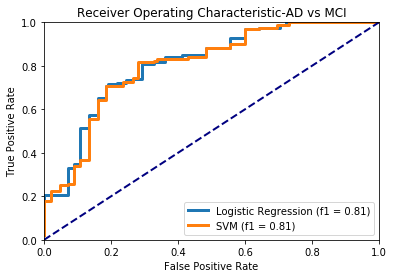

In [14]:
from sklearn.metrics import roc_curve, auc,f1_score
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr['lr'], tpr['lr'], _ = roc_curve(base_labels, lr_all_scores)
roc_auc['lr'] = auc(fpr['lr'], tpr['lr'])
#f1['lr']=f1_score(fpr['lr'], tpr['lr'])
fpr['svm'], tpr['svm'], _ = roc_curve(base_labels, svm_all_scores)
roc_auc['svm'] = auc(fpr['svm'], tpr['svm'])
#f1['svm']=f1_score(fpr['svm'], tpr['svm'])
#fpr['gcn'], tpr['gcn'], _ = roc_curve(all_labels, all_scores)
#roc_auc['gcn'] = auc(fpr['gcn'], tpr['gcn'])

plt.figure()
#plt.plot(fpr['lr'], tpr['lr'], lw=3, label='Logistic Regression (area = %0.2f)' % roc_auc['lr'] )
plt.plot(fpr['lr'], tpr['lr'], lw=3, label='Logistic Regression (f1 = %0.2f)' %np.mean(lr_f1s) )
#plt.plot(fpr['lr'], tpr['lr'], lw=3, label='Logistic Regression (f1 = %0.2f)' % f1['lr'] )
#plt.plot(fpr['svm'], tpr['svm'], lw=3, label='SVM (area = %0.2f)' % roc_auc['svm'] )
plt.plot(fpr['svm'], tpr['svm'], lw=3, label='SVM (f1 = %0.2f)' %np.mean(svm_f1s))
#plt.plot(fpr['svm'], tpr['svm'], lw=3, label='SVM (f1 = %0.2f)' % f1['svm'] )
#plt.plot(fpr['gcn'], tpr['gcn'], lw=3, label='GCN (area = %0.2f)' % roc_auc['gcn'])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic-AD vs MCI')
plt.legend(loc="lower right")
#plt.savefig('10x_Combined_ROC.eps')
plt.savefig('ROC_AD-MCI_connectome.eps')
plt.show()